Inverse network with 20 output unit was fitted in Liu(2018). 
They used 500k training samples.

Noting that search space is large, (2^20 = 1M) 
I reduce output unit size to 6 and try to replicate the work.

* 2^4 = 16 
* 8^4 = 4k 
* 2^6 = 64 
* 8^6 = 200k 
* 2^8 = 256 
* 8^8 = 16M 

I used GeForce GTX 960 for network training

In [1]:
import inverse_design
def test(inv, df):
    tests = [inv.test(df) for _ in range(10)]

    print(f"Forward network, MSE\n = {[round(t['forward']['mse'].numpy(),4) for t in tests]}")
    print(f"Inverse network, MSE\n = {[round(t['inverse']['mse'].numpy(),4) for t in tests]}")

    import numpy as np
    import matplotlib.pyplot as plt
    print()
    print("===Selected results===")
    chosen_forward = tests[np.argmin([t["forward"]["mse"] for t in tests])]['forward']
    chosen_inverse = tests[np.argmin([t["inverse"]["mse"] for t in tests])]['inverse']
    print(f"Forward network, MSE = {chosen_forward['mse']}")
    plt.plot(chosen_forward["true"][0],chosen_forward["true"][1],chosen_forward["pred"][0],chosen_forward["pred"][1])
    plt.show()
    print(f"Inverse network, MSE = {chosen_inverse['mse']}")
    plt.plot(chosen_inverse["true"][0],chosen_inverse["true"][1],chosen_inverse["pred"][0],chosen_inverse["pred"][1])
    plt.show()

## Test run

Forward training train/test loss


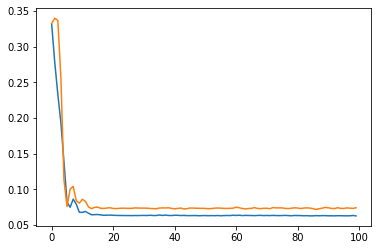

Tandem training train/test loss


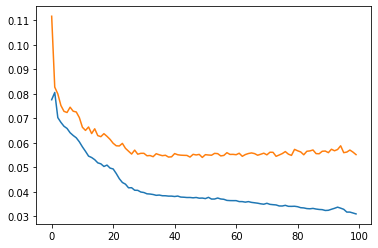

INFO:tensorflow:Assets written to: models/model_foward_b896d787bdb61e4c4ef8a7442a708a5f_test/assets
INFO:tensorflow:Assets written to: models/model_backward_b896d787bdb61e4c4ef8a7442a708a5f_test/assets
INFO:tensorflow:Assets written to: models/model_inverse_b896d787bdb61e4c4ef8a7442a708a5f_test/assets


In [2]:
config = {
    "simulation_count" : 1000,
    "layer_count" : 4,
    "spectral_range" : (0.15,0.25),
    "spectral_resolution" : 200,
    "n1":1.4,
    "n2":2.1,
    "d_min":10e-9,
    "d_max":150e-9
}
df = inverse_design.calculate_spectrum_all(config)
df = inverse_design.filter_similar_spectrum(config, df, thres_ratio = 0.1, plot=False)
inv = inverse_design.inverse_model(config)
inv.train(df, train_epochs=100)
inv.show_history()
inv.save_model("test")

Forward network, MSE
 = [0.0359, 0.0813, 0.0748, 0.056, 0.1937, 0.2001, 0.056, 0.0808, 0.1818, 0.0617]
Inverse network, MSE
 = [0.1476, 0.1697, 0.2245, 0.1599, 0.2979, 0.1562, 0.1599, 0.1322, 0.1103, 0.1963]

===Selected results===
Forward network, MSE = 0.03594237193465233


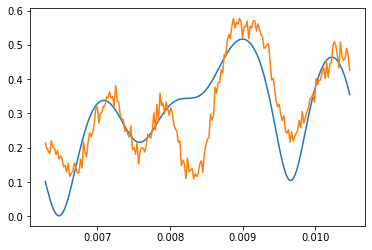

Inverse network, MSE = 0.11029697405214188


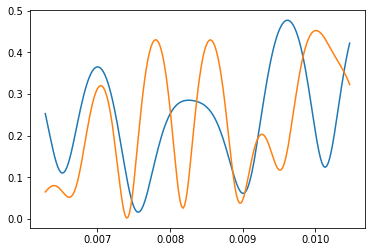

In [3]:
test(inv,df)

In [4]:
inv.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               2500      
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 200)               100200    
Total params: 603,700
Trainable params: 0
Non-trainable params: 603,700
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 500)               100500    
____________________________

## Inverse design with 10k search

In [ ]:
config = {
    "simulation_count" : 10000,
    "layer_count" : 6,
    "spectral_range" : (0.15,0.25),
    "spectral_resolution" : 200,
    "n1":1.4,
    "n2":2.1,
    "d_min":10e-9,
    "d_max":150e-9
}
df = inverse_design.calculate_spectrum_all(config)
# df = inverse_design.filter_similar_spectrum(config, df, thres_ratio = 0.1, plot=False)
inv = inverse_design.inverse_model(config)
inv.train(df, train_epochs=1000)
inv.show_history()
inv.test(df)
inv.save_model("D0010_S0010_E0001") #parameter space size, search space size, train epoch

## Inverse design with filtered 1k search

Overfitting occurs in tandem network training.

* Inaccurate forward network may caused this problem.

* Or the model have no predictive power (loss is ruled by some extreme errors)

In [ ]:
config = {
    "simulation_count" : 10000,
    "layer_count" : 6,
    "spectral_range" : (0.15,0.25),
    "spectral_resolution" : 200,
    "n1":1.4,
    "n2":2.1,
    "d_min":10e-9,
    "d_max":150e-9
}
df = inverse_design.calculate_spectrum_all(config)
df = inverse_design.filter_similar_spectrum(config, df, thres_ratio = 0.1, plot=False)
inv = inverse_design.inverse_model(config)
inv.train(df, train_epochs=1000)
inv.show_history()
inv.test(df)
inv.save_model("D0010_S0001_E0001") #parameter space size, search space size, train epoch

## inverse design with filtered 10k search

Model converges better than unfiltered result.

However, inverse design test result could be improved.

* mse ( = sq_sum / 200) < 0.002
* cost ( = sq_sum / 2 ) < 0.2

This is similar to the paper

In [ ]:
config = {
    "simulation_count" : 100000,
    "layer_count" : 6,
    "spectral_range" : (0.15,0.25),
    "spectral_resolution" : 200,
    "n1":1.4,
    "n2":2.1,
    "d_min":10e-9,
    "d_max":150e-9
}
df = inverse_design.calculate_spectrum_all(config)

# split filter due to memory issue
import pandas as pd
df_1 = inverse_design.filter_similar_spectrum(config, df.iloc[     :20000,:], thres_ratio = 0.2, plot=False)
df_2 = inverse_design.filter_similar_spectrum(config, df.iloc[20000:40000,:], thres_ratio = 0.2, plot=False)
df_3 = inverse_design.filter_similar_spectrum(config, df.iloc[40000:60000,:], thres_ratio = 0.2, plot=False)
df_4 = inverse_design.filter_similar_spectrum(config, df.iloc[60000:80000,:], thres_ratio = 0.2, plot=False)
df_5 = inverse_design.filter_similar_spectrum(config, df.iloc[80000:     ,:], thres_ratio = 0.2, plot=False)
df = pd.concat([df_1,df_2,df_3,df_4,df_5], ignore_index=True)
df = inverse_design.filter_similar_spectrum(config, df, thres_ratio = 0.5, plot=False)

inv = inverse_design.inverse_model(config)
inv.train(df, train_epochs=1000)
inv.show_history()
inv.test(df)
inv.save_model("D0100_S0010_E0001") #parameter space size, search space size, train epoch

## Model accuracy impact check

To check impact of forward network accuracy,
narrow spectral range with more training epoch was applied

In [ ]:
config = {
    "simulation_count" : 100000,
    "layer_count" : 6,
    "spectral_range" : (0.15,0.20),
    "spectral_resolution" : 100,
    "n1":1.4,
    "n2":2.1,
    "d_min":10e-9,
    "d_max":150e-9
}
df = inverse_design.calculate_spectrum_all(config)

# split filter due to memory issue
import pandas as pd
df_1 = inverse_design.filter_similar_spectrum(config, df.iloc[     :20000,:], thres_ratio = 0.2, plot=False)
df_2 = inverse_design.filter_similar_spectrum(config, df.iloc[20000:40000,:], thres_ratio = 0.2, plot=False)
df_3 = inverse_design.filter_similar_spectrum(config, df.iloc[40000:60000,:], thres_ratio = 0.2, plot=False)
df_4 = inverse_design.filter_similar_spectrum(config, df.iloc[60000:80000,:], thres_ratio = 0.2, plot=False)
df_5 = inverse_design.filter_similar_spectrum(config, df.iloc[80000:     ,:], thres_ratio = 0.2, plot=False)
df = pd.concat([df_1,df_2,df_3,df_4,df_5], ignore_index=True)
df = inverse_design.filter_similar_spectrum(config, df, thres_ratio = 0.5, plot=False)

inv = inverse_design.inverse_model(config)
inv.train(df, train_epochs=10000)
inv.show_history()
inv.test(df)
inv.save_model("D0100_S0010_E0010_reduced") #parameter space size, search space size, train epoch